# Roughness prediction using DNN

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import random
import hashlib
import pandas as pd
from tqdm import tqdm
import math
from sklearn.preprocessing import MinMaxScaler
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR

K means clustering to get 5 different levels

In [2]:
# K means clustering to get 5 different levels
class SensorDataSet(Dataset):
    def __init__(self, dataframe):
        self.features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)  # except last col
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)   # only last col

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
# Model and training pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Model and training pipeline

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.Dropout(p=0.5),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            # nn.BatchNorm1d(128),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x) ################################################################################################################################################



def train_model(model, criterion, optimizer, train_loader, val_loader, lr_scheduler, epochs=20, diplay_step=5):
    # model = copy.deepcopy(model)
    val_loss_history = []
    train_loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        num_data = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Training epooch {epoch+1}", leave=False):
            X_batch = X_batch.to(device)  # Move data to device
            y_batch = y_batch.to(device)  # Move data to device
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            num_data += X_batch.shape[0]

            # print(train_loss)

        lr_scheduler.step()

        train_loss = train_loss / num_data
        train_loss_history.append(train_loss)
        # print(num_data)
        # exit()
        # evaluate
        val_loss = validate_model(model, criterion, val_loader)
        val_loss_history.append(val_loss)

        if (epoch+1)%diplay_step==0 or epoch==0:
            for param_group in optimizer.param_groups:
                lr = param_group['lr']

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, learning rate = {lr}")

    return train_loss_history, val_loss_history

def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    num_data = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)  # Move data to device
            y_batch = y_batch.to(device)  # Move data to device
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            num_data += X_batch.shape[0]

    return val_loss / num_data

# Train and evaluation

In [4]:
import pandas as pd

# Read your actual dataset
data = pd.read_csv("shuffled_merged_dataset.csv")
data

,AccelX,AccelY,AccelZ,GyroX,GyroY,GyroZ,roughness_level
0,-0.626875,-3.439519,-10.617172,-0.180465,-0.317675,0.187122,3
1,-1.178420,-3.617460,-9.926802,-0.269507,-0.315197,0.116036,3
2,-1.115120,-3.429622,-9.977728,-0.254790,-0.313206,0.117355,3
3,-0.874328,-3.614339,-10.381597,-0.209030,-0.314444,0.164502,3
4,-2.233994,-3.408987,-10.136022,0.028711,0.132000,-0.182818,5
...,...,...,...,...,...,...,...
500058,-0.698536,-3.200152,-10.323553,-0.200335,-0.326858,0.171499,3
500059,-1.847407,-5.464539,-9.969243,-0.038473,0.090332,-0.142721,4
500060,-7.515492,4.658358,-9.427542,-0.264625,-0.061964,-0.300263,2
500061,-5.092721,-1.140965,-9.004563,-0.387076,-0.156158,-0.123806,2


In [5]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

train_set_ = SensorDataSet(train_set)
val_set_ = SensorDataSet(val_set)
# dataset = SensorDataSet(normalized_data)
batch_size = 4096
train_loader = DataLoader(train_set_, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_, batch_size=batch_size, shuffle=True)

In [6]:
model = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=25)

In [7]:
validate_model(model, criterion, val_loader)

0.002734872337537282

In [8]:
# data = train_set_
# # data = val_set_

# test_cases = []
# for i in range(10):
#     test_cases.append(random.randint(0, len(train_set)-1))
# for i in range(len(test_cases)):
#     print(train_set.iloc[i, :])

#     y = torch.tensor(train_set.iloc[i, -1], dtype=torch.float32)
#     x = np.array(train_set)[i, :-1]
#     x = torch.tensor(x, dtype=torch.float32)
#     x = x.unsqueeze(0)
#     print(f'predicted roughness by trained model: {model(x).item()}')
#     print(f'Error {criterion(model(x), y)}')
#     print()

Epoch 1/100, Train Loss: 0.0004, Val Loss: 0.0001, learning rate = 9.96057350657239e-05


Epoch 10/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 6.545084971874737e-05


Epoch 20/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 9.549150281252635e-06


Epoch 30/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 9.549150281252611e-06


Epoch 40/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 6.545084971874738e-05


Epoch 50/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 0.00010000000000000002


Epoch 60/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 6.545084971874744e-05


Epoch 70/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 9.54915028125264e-06


Epoch 80/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 9.54915028125275e-06


Epoch 90/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 6.545084971874826e-05


Epoch 100/100, Train Loss: 0.0001, Val Loss: 0.0001, learning rate = 0.00010000000000000137


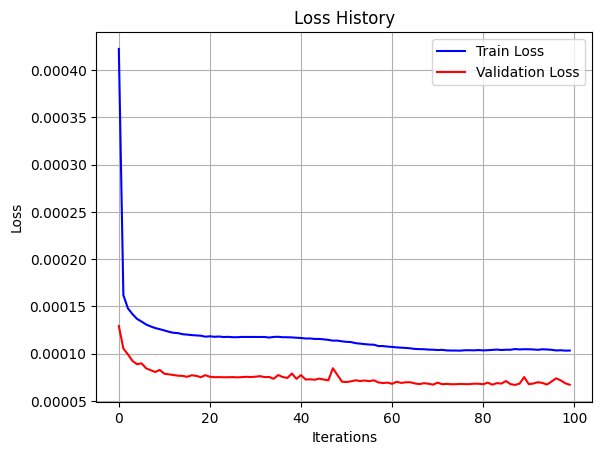

In [9]:
train_loss_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, val_loader, lr_scheduler, epochs=100, diplay_step=10)

plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
torch.save(model.state_dict(),"trained_dnn.pth")

In [11]:
validate_model(model, criterion, val_loader)

6.689502965765917e-05

In [12]:
train_set

,AccelX,AccelY,AccelZ,GyroX,GyroY,GyroZ,roughness_level
307623,-5.564547,0.963827,-10.960010,0.031176,0.034019,0.075389,4
429051,-3.069663,-3.587358,-10.296767,-0.376189,0.041098,-0.102898,2
207020,-0.811955,-3.525211,-10.170810,-0.238886,-0.291445,0.153067,3
145637,-1.877576,-2.298230,-10.918171,-0.030872,-0.011816,-0.064145,4
328364,-2.991185,-5.161786,-9.552141,0.006225,0.022238,0.191696,4
...,...,...,...,...,...,...,...
259178,-5.509113,-0.327937,-10.598792,-0.003637,-0.018569,-0.144426,4
365838,-3.008083,-1.223226,-9.055197,0.114481,0.073135,0.052714,4
131932,-2.569808,1.616088,-10.660953,-0.145014,-0.175972,-0.346561,2
146867,0.210126,-5.278486,-9.492534,-0.013912,-0.153394,0.243265,1


In [13]:
train_set_

In [29]:
data = train_set_
# data = val_set_

test_cases = []
with torch.no_grad():
  for i in range(10):
      test_cases.append(random.randint(0, len(train_set)-1))
  for i in range(len(test_cases)):
      print(train_set.iloc[i, :])

      y = torch.tensor(train_set.iloc[i, -1], dtype=torch.float32).to(device) # Move y to device
      x = np.array(train_set)[i, :-1]
      x = torch.tensor(x, dtype=torch.float32).to(device)   # Move x to device
      x = x.unsqueeze(0)

      # Make prediction and round it
      y_pred = model(x).item()
      rounded_y_pred = round(y_pred)  # Round the prediction

      print(f'predicted roughness by trained model: {rounded_y_pred}') # Print rounded prediction
      print(f'Error {criterion(torch.tensor(rounded_y_pred, device=device), y)/ max(rounded_y_pred, y.item()): .2f} %') # Calculate error with rounded prediction
      print()

AccelX             -5.564547
AccelY              0.963827
AccelZ            -10.960010
GyroX               0.031176
GyroY               0.034019
GyroZ               0.075389
roughness_level     4.000000
Name: 307623, dtype: float64
predicted roughness by trained model: 4
Error  0.00 %

AccelX             -3.069663
AccelY             -3.587358
AccelZ            -10.296767
GyroX              -0.376189
GyroY               0.041098
GyroZ              -0.102898
roughness_level     2.000000
Name: 429051, dtype: float64
predicted roughness by trained model: 2
Error  0.00 %

AccelX             -0.811955
AccelY             -3.525211
AccelZ            -10.170810
GyroX              -0.238886
GyroY              -0.291445
GyroZ               0.153067
roughness_level     3.000000
Name: 207020, dtype: float64
predicted roughness by trained model: 3
Error  0.00 %

AccelX             -1.877576
AccelY             -2.298230
AccelZ            -10.918171
GyroX              -0.030872
GyroY              -0.0

## Summarization:
- Simple DNN can learn underlying relation in 6d data
- Relatively fast training with small dimensionality
- *Overfitting issue* hurts performance. Attempts:
    - Reduce model size
    - Add batchnorm, dropout
    - Increase batch_size
    - Learning rate scheduler (decaying)

## Future work:
- Test on real data
- Explore other architectures
- Physics-informed model (need some kinds of equation to describe the system)
- other regularization technique to improve generalization and robustness
- Finetunig hyperparameters (learning rate, model size, depth, etc.), architecture search for automatic finetuning.


# Concerns:
- Regarding simulation: Tool for simulation (Simulink, MATLAB, labview, ROS, etc)? How can we attain the Robot arm and surface model (for simulation)?
- Which kind of controller we plan to use for our system??
- How can we actually integrate trained DNN to our simulation (some available refernces ? ) ??


In [26]:
data = val_set_
# Test on 1000 random samples from the validation set
num_samples = 1000
correct_predictions = 0

with torch.no_grad():
    for _ in range(num_samples):
        # Generate a random index within the validation set
        random_index = random.randint(0, len(val_set) - 1)

        # Get the input features and target value from the validation set
        y_true = val_set.iloc[random_index, -1]  # Target value
        x = np.array(val_set)[random_index, :-1]  # Input features
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.unsqueeze(0)

        # Make a prediction
        y_pred = model(x).item()

        # Check if the prediction is correct (rounded to nearest integer)
        if round(y_pred) == round(y_true):
            correct_predictions += 1

# Calculate the accuracy as a percentage
accuracy = (correct_predictions / num_samples) * 100

# Print the accuracy
print(f"Accuracy on {num_samples} random samples from the validation set: {accuracy:.2f}%")

Accuracy on 1000 random samples from the validation set: 82.70%


In [28]:
data = train_set_  # Use train_set_ instead of val_set_

# Test on 1000 random samples from the training set
num_samples = 100
correct_predictions = 0

with torch.no_grad():
    for _ in range(num_samples):
        # Generate a random index within the training set
        random_index = random.randint(0, len(train_set) - 1)  # Use len(train_set)

        # Get the input features and target value from the training set
        y_true = train_set.iloc[random_index, -1]  # Use train_set
        x = np.array(train_set)[random_index, :-1]  # Use train_set
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.unsqueeze(0)

        # Make a prediction
        y_pred = model(x).item()

        # Check if the prediction is correct (rounded to nearest integer)
        if round(y_pred) == round(y_true):
            correct_predictions += 1

# Calculate the accuracy as a percentage
accuracy = (correct_predictions / num_samples) * 100

# Print the accuracy
print(f"Accuracy on {num_samples} random samples from the training set: {accuracy:.2f}%")  # Changed to training set

Accuracy on 100 random samples from the training set: 83.00%


In [33]:
data = train_set_
# data = val_set_

test_cases = []
correct_predictions = 0  # Initialize correct predictions counter
num_samples = 100  # Define the number of samples to test

with torch.no_grad():
    for i in range(num_samples):
        test_cases.append(random.randint(0, len(train_set) - 1))

    for i in range(len(test_cases)):
        print(train_set.iloc[i, :])

        y = torch.tensor(train_set.iloc[i, -1], dtype=torch.float32).to(device)
        x = np.array(train_set)[i, :-1]
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.unsqueeze(0)

        y_pred = model(x).item()
        rounded_y_pred = round(y_pred)

        print(f'predicted roughness by trained model: {rounded_y_pred}')
        print(f'Error {criterion(torch.tensor(rounded_y_pred, device=device), y) / max(rounded_y_pred, y.item()):.2f} %')

        # Check for correct prediction and update counter
        if rounded_y_pred == round(y.item()):  # Compare rounded values
            correct_predictions += 1

        print()

# Calculate and print accuracy
accuracy = (correct_predictions / num_samples) * 100
print(f"Accuracy on {num_samples} random samples from the training set: {accuracy:.2f}%")

AccelX             -5.564547
AccelY              0.963827
AccelZ            -10.960010
GyroX               0.031176
GyroY               0.034019
GyroZ               0.075389
roughness_level     4.000000
Name: 307623, dtype: float64
predicted roughness by trained model: 4
Error 0.00 %

AccelX             -3.069663
AccelY             -3.587358
AccelZ            -10.296767
GyroX              -0.376189
GyroY               0.041098
GyroZ              -0.102898
roughness_level     2.000000
Name: 429051, dtype: float64
predicted roughness by trained model: 2
Error 0.00 %

AccelX             -0.811955
AccelY             -3.525211
AccelZ            -10.170810
GyroX              -0.238886
GyroY              -0.291445
GyroZ               0.153067
roughness_level     3.000000
Name: 207020, dtype: float64
predicted roughness by trained model: 3
Error 0.00 %

AccelX             -1.877576
AccelY             -2.298230
AccelZ            -10.918171
GyroX              -0.030872
GyroY              -0.0118